In [1]:
!pip install datasets
from datasets import load_dataset

ds = load_dataset("jxm/mpqa")

README.md:   0%|          | 0.00/650 [00:00<?, ?B/s]

data/train-00000-of-00001-a7df005a1b0788(…):   0%|          | 0.00/141k [00:00<?, ?B/s]

data/test-00000-of-00001-05fc5ca1c399669(…):   0%|          | 0.00/33.7k [00:00<?, ?B/s]

data/dev-00000-of-00001-8814a3252cc44468(…):   0%|          | 0.00/6.19k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8603 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/256 [00:00<?, ? examples/s]

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 8603
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2000
    })
    dev: Dataset({
        features: ['sentence', 'label'],
        num_rows: 256
    })
})

# **DistilBERT**

In [5]:
!pip install pennylane
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
import pennylane as qml
from pennylane import numpy as pnp
import re
import warnings
import re
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')
# Label encoding for 'status' column
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
import pennylane as qml
# Convert data to PyTorch DataLoader format
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import ParameterSampler
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import torch
from sklearn.preprocessing import label_binarize
import time
import random
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel

# ---------------------------
# Load MPQA Dataset
# ---------------------------
ds = load_dataset("jxm/mpqa")

# Convert train split to pandas (MPQA already split)
df = ds["train"].to_pandas()

print(df.head())
print(df.shape)

# MPQA typically has columns: 'text' and 'label'
# If column name is different, print df.columns to check.

# Rename for compatibility with your previous code
df = df.rename(columns={"text": "sentence"})

# ---------------------------
# Basic Preprocessing
# ---------------------------

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['cleaned_text'] = df['sentence'].apply(preprocess_text)

# ---------------------------
# Remove Stopwords
# ---------------------------

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    statement = statement.lower()
    statement = re.sub(r'[^\w\s]', '', statement)
    statement = re.sub(r'\d+', '', statement)
    words = statement.split()
    words = [word for word in words if word not in stop_words]
    cleaned_statement = ' '.join(words)
    return cleaned_statement

df['cleaned_text'] = df['cleaned_text'].apply(clean_statement)

print(df.head())

# ---------------------------
# Label Encoding
# ---------------------------
# MPQA labels are usually already numeric (0,1)
# But we keep this step for safety

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

print(df['label'].value_counts())

# ---------------------------
# Balance Dataset
# ---------------------------

majority_class = df['label'].value_counts().idxmax()
minority_class = df['label'].value_counts().idxmin()

df_majority = df[df['label'] == majority_class]
df_minority = df[df['label'] == minority_class]

# Downsample majority
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

# Combine
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Class Distribution:")
print(df_balanced['label'].value_counts())

df_balanced.head()


# Initialize the tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokens = tokenizer.batch_encode_plus(
    df['cleaned_text'].tolist(),
    max_length=128,
    padding="max_length",   # <-- updated
    truncation=True,
    return_tensors="pt"
)

# Convert to tensors
input_ids = torch.tensor(tokens['input_ids'])
attention_masks = torch.tensor(tokens['attention_mask'])
labels = torch.tensor(df['label'].values)

# Split the data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.2)


train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=32)

# Create a quantum node (circuit)
dev = qml.device("default.qubit", wires=2)  # or 'default.qubit'

@qml.qnode(dev)
@qml.qnode(dev)
def quantum_circuit(weights, inputs):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.RX(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)

    qml.CNOT(wires=[0, 1])

    qml.RZ(weights[0], wires=0)
    qml.RZ(weights[1], wires=1)

    return qml.expval(qml.PauliZ(0))

class QBiLSTM(nn.Module):
    def __init__(self):
        super(QBiLSTM, self).__init__()

        self.bert = AutoModel.from_pretrained("distilbert-base-uncased")

        # 🔁 BiLSTM instead of LSTM
        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        # 128 × 2 because BiLSTM
        self.fc = nn.Linear(256, 2)

    def quantum_layer(self, inputs):
        processed_features = []

        for feature_vector in inputs:
            features_for_quantum = feature_vector[:2]
            q_out = quantum_circuit(
                torch.randn(2, dtype=torch.float32),
                features_for_quantum
            )
            processed_features.append(q_out)

        return torch.stack(processed_features).unsqueeze(1)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # BiLSTM output
        lstm_output, _ = self.bilstm(bert_output.last_hidden_state)

        # Last timestep (batch, 256)
        last_hidden = lstm_output[:, -1, :]

        _ = self.quantum_layer(last_hidden)

        # Classification
        output = self.fc(last_hidden)
        return output


model = QBiLSTM()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define hyperparameter search space
param_grid = {
    'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32],
    'epochs': [3, 5, 7]
}

num_samples = 5  
param_list = list(ParameterSampler(param_grid, n_iter=num_samples, random_state=42))

best_model = None
best_val_accuracy = 0.0
best_params = None

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Loop through each random set of hyperparameters
for idx, params in enumerate(param_list):
    print(f"Testing configuration {idx + 1}: {params}")

    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Define optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch

            # Move tensors to the same device
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = nn.CrossEntropyLoss()(outputs, b_labels)
            total_train_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        all_preds = []
        all_labels = []

        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = batch

            # Move tensors to the same device
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)
                loss = nn.CrossEntropyLoss()(outputs, b_labels)
                total_val_loss += loss.item()

                logits = outputs.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                total_val_accuracy += flat_accuracy(logits, label_ids)

                all_preds.extend(np.argmax(logits, axis=1).flatten())
                all_labels.extend(label_ids.flatten())

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_accuracy:.4f}")
        print(f"Time: {elapsed_time:.2f} seconds")

        # Save best model
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_model = model.state_dict()
            best_params = params
            torch.save(best_model, 'best_model.pth')
            print(f"New best model saved with accuracy: {best_val_accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))



# Define search space for hyperparameters
epochs = 5
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
optimizers = ['adamw', 'adam', 'rmsprop', 'sgd']

# Number of random samples to try
num_samples = 5

# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to get optimizer
def get_optimizer(optimizer_name, model_parameters, lr):
    if optimizer_name == 'adamw':
        return optim.AdamW(model_parameters, lr=lr)
    elif optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_parameters, lr=lr)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr)

# Randomly sample hyperparameter combinations
random_hyperparams = [
    {
        "optimizer": random.choice(optimizers),
        "learning_rate": random.choice(learning_rates),
        "batch_size": random.choice(batch_sizes),
    }
    for _ in range(num_samples)
]

best_accuracy = 0
best_params = {}

# Iterate over randomly chosen hyperparameter sets
for params in random_hyperparams:
    optimizer_name = params["optimizer"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]

    # Initialize data loaders
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

    # Define optimizer and scheduler
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Move model to device
    model.to(device)

    for epoch in range(epochs):
        start_time = time.time()

        # Training
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = nn.CrossEntropyLoss()(outputs, b_labels)
            total_train_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)
                loss = nn.CrossEntropyLoss()(outputs, b_labels)
                total_val_loss += loss.item()

                logits = outputs.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                total_val_accuracy += flat_accuracy(logits, label_ids)

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)

        elapsed_time = time.time() - start_time

        print(f"Optimizer: {optimizer_name} | Learning Rate: {lr} | Batch Size: {batch_size}")
        print(f"Epoch {epoch+1}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_accuracy:.4f}")
        print(f"Time: {elapsed_time:.2f} seconds")
        print("-" * 50)

        # Update best parameters if validation accuracy improves
        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            best_params = {"optimizer": optimizer_name, "learning_rate": lr, "batch_size": batch_size}

print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Parameters: Optimizer = {best_params['optimizer']}, Learning Rate = {best_params['learning_rate']}, Batch Size = {best_params['batch_size']}")


                                  sentence  label
0         would not find it at all strange      0
1  that four shots would solve the problem      0
2                                  in turn      0
3                                  because      0
4                                 regained      0
(8603, 2)
                                  sentence  label  \
0         would not find it at all strange      0   
1  that four shots would solve the problem      0   
2                                  in turn      0   
3                                  because      0   
4                                 regained      0   

                     cleaned_text  
0              would find strange  
1  four shots would solve problem  
2                            turn  
3                                  
4                        regained  
label
0    6292
1    2311
Name: count, dtype: int64
Balanced Class Distribution:
label
0    2311
1    2311
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2026-02-12 04:48:20.914159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770871701.084680      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770871701.134611      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770871701.543849      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770871701.543904      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770871701.543908      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Testing configuration 1: {'learning_rate': 1e-05, 'epochs': 7, 'batch_size': 16}
Epoch 1 | Train Loss: 0.4572 | Train Accuracy: 0.7857
Validation Loss: 0.3413 | Validation Accuracy: 0.8560
Time: 74.61 seconds
New best model saved with accuracy: 0.8560
Epoch 2 | Train Loss: 0.3040 | Train Accuracy: 0.8733
Validation Loss: 0.3301 | Validation Accuracy: 0.8648
Time: 73.44 seconds
New best model saved with accuracy: 0.8648
Epoch 3 | Train Loss: 0.2636 | Train Accuracy: 0.8954
Validation Loss: 0.3282 | Validation Accuracy: 0.8729
Time: 73.20 seconds
New best model saved with accuracy: 0.8729
Epoch 4 | Train Loss: 0.2320 | Train Accuracy: 0.9126
Validation Loss: 0.3398 | Validation Accuracy: 0.8729
Time: 74.00 seconds
Epoch 5 | Train Loss: 0.2112 | Train Accuracy: 0.9198
Validation Loss: 0.3385 | Validation Accuracy: 0.8754
Time: 74.54 seconds
New best model saved with accuracy: 0.8754
Epoch 6 | Train Loss: 0.1890 | Train Accuracy: 0.9314
Validation Loss: 0.3470 | Validation Accuracy: 0.8735

===== Evaluation Metrics =====
Accuracy     : 0.8553
Precision    : 0.7238
Recall       : 0.7380
Sensitivity : 0.7380
Specificity : 0.8979
F1-score    : 0.7308
AUC         : 0.8906

===== Classification Report =====
              precision    recall  f1-score   support

           0     0.9043    0.8979    0.9011      1263
           1     0.7238    0.7380    0.7308       458

    accuracy                         0.8553      1721
   macro avg     0.8140    0.8179    0.8159      1721
weighted avg     0.8563    0.8553    0.8558      1721



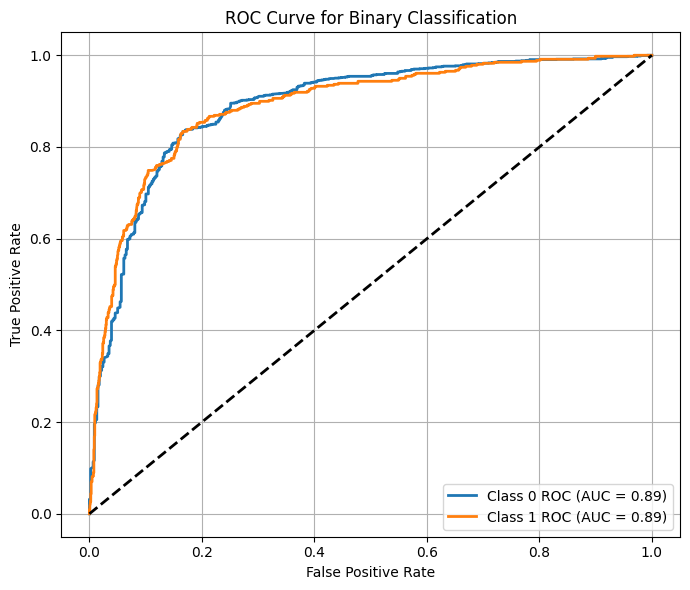

In [6]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_binary_model(model, dataloader, device):
    model.eval()
    all_true_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_input_ids, b_input_mask)
            probs = torch.softmax(outputs, dim=1)

            all_true_labels.append(b_labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # Convert to numpy
    all_true_labels = np.concatenate(all_true_labels)
    all_probs = np.concatenate(all_probs)
    all_preds = np.argmax(all_probs, axis=1)

    # ================= Metrics =================
    tn, fp, fn, tp = confusion_matrix(all_true_labels, all_preds).ravel()

    accuracy = accuracy_score(all_true_labels, all_preds)
    precision = precision_score(all_true_labels, all_preds)
    recall = recall_score(all_true_labels, all_preds)          # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(all_true_labels, all_preds)
    auc = roc_auc_score(all_true_labels, all_probs[:, 1])

    # ================= Print metrics =================
    print("===== Evaluation Metrics =====")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Sensitivity : {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1-score    : {f1:.4f}")
    print(f"AUC         : {auc:.4f}")

    # ================= Classification Report =================
    print("\n===== Classification Report =====")
    print(classification_report(all_true_labels, all_preds, digits=4))

    # ================= ROC Curve (Both Classes) =================
    fpr_0, tpr_0, _ = roc_curve(all_true_labels, all_probs[:, 0], pos_label=0)
    fpr_1, tpr_1, _ = roc_curve(all_true_labels, all_probs[:, 1], pos_label=1)

    auc_0 = roc_auc_score(1 - all_true_labels, all_probs[:, 0])
    auc_1 = roc_auc_score(all_true_labels, all_probs[:, 1])

    plt.figure(figsize=(7, 6))
    plt.plot(fpr_0, tpr_0, label=f"Class 0 ROC (AUC = {auc_0:.2f})", lw=2)
    plt.plot(fpr_1, tpr_1, label=f"Class 1 ROC (AUC = {auc_1:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Binary Classification")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, specificity, f1, auc


accuracy, precision, recall, specificity, f1, auc = evaluate_binary_model(
    model, val_dataloader, device
)

In [7]:
import re, time, random, warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW

import nltk
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


# ---------------------------
# Load MPQA Dataset
# ---------------------------
ds = load_dataset("jxm/mpqa")

# Convert train split to pandas (MPQA already split)
df = ds["train"].to_pandas()

print(df.head())
print(df.shape)

# MPQA typically has columns: 'text' and 'label'
# If column name is different, print df.columns to check.

# Rename for compatibility with your previous code
df = df.rename(columns={"text": "sentence"})

# ---------------------------
# Basic Preprocessing
# ---------------------------

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['cleaned_text'] = df['sentence'].apply(preprocess_text)

# ---------------------------
# Remove Stopwords
# ---------------------------

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    statement = statement.lower()
    statement = re.sub(r'[^\w\s]', '', statement)
    statement = re.sub(r'\d+', '', statement)
    words = statement.split()
    words = [word for word in words if word not in stop_words]
    cleaned_statement = ' '.join(words)
    return cleaned_statement

df['cleaned_text'] = df['cleaned_text'].apply(clean_statement)

print(df.head())

# ---------------------------
# Label Encoding
# ---------------------------
# MPQA labels are usually already numeric (0,1)
# But we keep this step for safety

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

print(df['label'].value_counts())

# ---------------------------
# Balance Dataset
# ---------------------------

majority_class = df['label'].value_counts().idxmax()
minority_class = df['label'].value_counts().idxmin()

df_majority = df[df['label'] == majority_class]
df_minority = df[df['label'] == minority_class]

# Downsample majority
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

# Combine
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Class Distribution:")
print(df_balanced['label'].value_counts())

df_balanced.head()

print(df_balanced["label"].value_counts())
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokens = tokenizer(
    df_balanced["cleaned_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df_balanced["label"].values)
X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    input_ids, labels, attention_mask, test_size=0.2, random_state=42
)

train_data = TensorDataset(X_train, m_train, y_train)
val_data = TensorDataset(X_val, m_val, y_val)

train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=16)
val_loader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=16)
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def qc1(weights, x):
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([0,1])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc2(weights, x):
    qml.Hadamard(0)
    qml.RY(x[0], 0)
    qml.RX(x[1], 1)
    qml.CNOT([1,0])
    qml.RX(weights[0], 0)
    qml.RY(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc3(weights, x):
    for i in range(2):
        qml.Hadamard(i)
        qml.RX(x[i], i)
        qml.RY(weights[i], i)
        qml.RZ(weights[i], i)
    qml.CNOT([0,1])
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev, interface="torch")
def qc4(weights, x):
    qml.Hadamard(0)
    qml.CNOT([0,1])
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([1,0])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

QUANTUM_CIRCUITS = {
    "QC1": qc1,
    "QC2": qc2,
    "QC3": qc3,
    "QC4": qc4
}
class QBiLSTM(nn.Module):
    def __init__(self, quantum_circuit):
        super().__init__()
        self.qc = quantum_circuit
        self.q_weights = nn.Parameter(torch.randn(2))

        self.encoder = AutoModel.from_pretrained("distilbert-base-uncased")

        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(256, 2)

    def quantum_layer(self, x):
        q_outs = []
        for v in x:
            q_outs.append(self.qc(self.q_weights, v[:2]))
        return torch.stack(q_outs)

    def forward(self, input_ids, attention_mask):
        enc = self.encoder(input_ids, attention_mask).last_hidden_state
        lstm_out, _ = self.bilstm(enc)
        h = lstm_out[:, -1, :]

        _ = self.quantum_layer(h)  # quantum interaction

        return self.fc(h)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}

for name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n====== Training {name} ======")

    model = QBiLSTM(qc).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(10):
        print(f"\n--- Epoch {epoch+1}/10 ---")
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_loader, 1):
            ids, mask, y = [b.to(device) for b in batch]

            optimizer.zero_grad()
            out = model(ids, mask)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if step % 50 == 0:  # print every 50 steps
                print(f"Step {step}: Loss = {loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} finished. Avg Loss = {avg_loss:.4f}")

    # Evaluation
    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for batch in val_loader:
            ids, mask, y = [b.to(device) for b in batch]
            logits = model(ids, mask)
            preds.extend(torch.argmax(logits, 1).cpu().numpy())
            gold.extend(y.cpu().numpy())

    acc = accuracy_score(gold, preds)
    results[name] = acc

    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(gold, preds))

print("\n===== FINAL QUANTUM CIRCUIT COMPARISON =====")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                  sentence  label
0         would not find it at all strange      0
1  that four shots would solve the problem      0
2                                  in turn      0
3                                  because      0
4                                 regained      0
(8603, 2)
                                  sentence  label  \
0         would not find it at all strange      0   
1  that four shots would solve the problem      0   
2                                  in turn      0   
3                                  because      0   
4                                 regained      0   

                     cleaned_text  
0              would find strange  
1  four shots would solve problem  
2                            turn  
3                                  
4                        regained  
label
0    6292
1    2311
Name: count, dtype: int64
Balanced Class Distribution:
label
0    2311
1    2311
Name: count, dtype: int64
label
0    2311
1    2

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



====== Training QC1 ======

--- Epoch 1/10 ---
Step 50: Loss = 0.6426
Step 100: Loss = 0.4824
Step 150: Loss = 0.4929
Step 200: Loss = 0.2422
Epoch 1 finished. Avg Loss = 0.4499

--- Epoch 2/10 ---
Step 50: Loss = 0.1202
Step 100: Loss = 0.2069
Step 150: Loss = 0.2803
Step 200: Loss = 0.2999
Epoch 2 finished. Avg Loss = 0.3025

--- Epoch 3/10 ---
Step 50: Loss = 0.1300
Step 100: Loss = 0.0414
Step 150: Loss = 0.2195
Step 200: Loss = 0.0860
Epoch 3 finished. Avg Loss = 0.2204

--- Epoch 4/10 ---
Step 50: Loss = 0.1577
Step 100: Loss = 0.1735
Step 150: Loss = 0.0222
Step 200: Loss = 0.1640
Epoch 4 finished. Avg Loss = 0.1535

--- Epoch 5/10 ---
Step 50: Loss = 0.0218
Step 100: Loss = 0.0905
Step 150: Loss = 0.0550
Step 200: Loss = 0.0589
Epoch 5 finished. Avg Loss = 0.1258

--- Epoch 6/10 ---
Step 50: Loss = 0.1541
Step 100: Loss = 0.0323
Step 150: Loss = 0.0199
Step 200: Loss = 0.0318
Epoch 6 finished. Avg Loss = 0.1041

--- Epoch 7/10 ---
Step 50: Loss = 0.1894
Step 100: Loss = 0.0479

# **DeBARTA**

In [3]:
!pip install pennylane
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
import pennylane as qml
from pennylane import numpy as pnp
import re
import warnings
import re
import nltk

from nltk.corpus import stopwords
warnings.filterwarnings('ignore')
# Label encoding for 'status' column
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
import pennylane as qml
# Convert data to PyTorch DataLoader format
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import ParameterSampler
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import torch
from sklearn.preprocessing import label_binarize
import time
import random
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel

ds = load_dataset("jxm/mpqa")

# Convert train split to pandas (MPQA already split)
df = ds["train"].to_pandas()


def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove links
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

df['cleaned_text'] = df['sentence'].apply(preprocess_text)

df = df[df['cleaned_text'] != '[deleted]']
df = df[df['cleaned_text'] != '[removed]']

df.head()

# Download NLTK stopwords (only needed once)
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    # Convert to lowercase
    statement = statement.lower()

    # Remove special characters (punctuation, non-alphabetic characters)
    statement = re.sub(r'[^\w\s]', '', statement)

    # Remove numbers (optional, depending on your use case)
    statement = re.sub(r'\d+', '', statement)

    # Tokenize the statement (split into words)
    words = statement.split()

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Rejoin words into a cleaned statement
    cleaned_statement = ' '.join(words)

    return cleaned_statement

# Apply the cleaning function to the 'statement' column
df['cleaned_text'] = df['cleaned_text'].apply(clean_statement)

df


label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df.head()

# Check the number of samples per class
class_counts = df['label'].value_counts()
print(class_counts)
# Separate majority and minority classes
class_counts = df['label'].value_counts()
print(class_counts)

majority_class = df['label'].value_counts().idxmax()
minority_class = df['label'].value_counts().idxmin()

df_majority = df[df['label'] == majority_class]
df_minority = df[df['label'] == minority_class]

# Downsample majority to match minority
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

# Combine
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['label'].value_counts())


# Initialize the tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

tokens = tokenizer.batch_encode_plus(
    df['cleaned_text'].tolist(),
    max_length=128,
    padding="max_length",   # <-- updated
    truncation=True,
    return_tensors="pt"
)

# Convert to tensors
input_ids = torch.tensor(tokens['input_ids'])
attention_masks = torch.tensor(tokens['attention_mask'])
labels = torch.tensor(df['label'].values)

# Split the data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.2)


train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=32)

# Create a quantum node (circuit)
dev = qml.device("default.qubit", wires=2)  # or 'default.qubit'

@qml.qnode(dev)
def quantum_circuit(weights, inputs):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.RX(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)

    qml.CNOT(wires=[0, 1])

    qml.RZ(weights[0], wires=0)
    qml.RZ(weights[1], wires=1)

    return qml.expval(qml.PauliZ(0))

class QBiLSTM(nn.Module):
    def __init__(self):
        super(QBiLSTM, self).__init__()

        self.bert = AutoModel.from_pretrained("microsoft/deberta-v3-base")

        # 🔁 BiLSTM instead of LSTM
        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        # 128 × 2 because BiLSTM
        self.fc = nn.Linear(256, 2)

    def quantum_layer(self, inputs):
        processed_features = []

        for feature_vector in inputs:
            features_for_quantum = feature_vector[:2]
            q_out = quantum_circuit(
                torch.randn(2, dtype=torch.float32),
                features_for_quantum
            )
            processed_features.append(q_out)

        return torch.stack(processed_features).unsqueeze(1)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # BiLSTM output
        lstm_output, _ = self.bilstm(bert_output.last_hidden_state)

        # Last timestep (batch, 256)
        last_hidden = lstm_output[:, -1, :]

        _ = self.quantum_layer(last_hidden)

        # Classification
        output = self.fc(last_hidden)
        return output


model = QBiLSTM()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define hyperparameter search space
param_grid = {
    'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32],
    'epochs': [3, 5, 7]
}

num_samples = 5  
param_list = list(ParameterSampler(param_grid, n_iter=num_samples, random_state=42))

best_model = None
best_val_accuracy = 0.0
best_params = None

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Loop through each random set of hyperparameters
for idx, params in enumerate(param_list):
    print(f"Testing configuration {idx + 1}: {params}")

    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Define optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch

            # Move tensors to the same device
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = nn.CrossEntropyLoss()(outputs, b_labels)
            total_train_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        all_preds = []
        all_labels = []

        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = batch

            # Move tensors to the same device
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)
                loss = nn.CrossEntropyLoss()(outputs, b_labels)
                total_val_loss += loss.item()

                logits = outputs.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                total_val_accuracy += flat_accuracy(logits, label_ids)

                all_preds.extend(np.argmax(logits, axis=1).flatten())
                all_labels.extend(label_ids.flatten())

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_accuracy:.4f}")
        print(f"Time: {elapsed_time:.2f} seconds")

        # Save best model
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_model = model.state_dict()
            best_params = params
            torch.save(best_model, 'best_model.pth')
            print(f"New best model saved with accuracy: {best_val_accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))



# Define search space for hyperparameters
epochs = 5
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
optimizers = ['adamw', 'adam', 'rmsprop', 'sgd']

# Number of random samples to try
num_samples = 5

# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to get optimizer
def get_optimizer(optimizer_name, model_parameters, lr):
    if optimizer_name == 'adamw':
        return optim.AdamW(model_parameters, lr=lr)
    elif optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_parameters, lr=lr)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr)

# Randomly sample hyperparameter combinations
random_hyperparams = [
    {
        "optimizer": random.choice(optimizers),
        "learning_rate": random.choice(learning_rates),
        "batch_size": random.choice(batch_sizes),
    }
    for _ in range(num_samples)
]

best_accuracy = 0
best_params = {}

# Iterate over randomly chosen hyperparameter sets
for params in random_hyperparams:
    optimizer_name = params["optimizer"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]

    # Initialize data loaders
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

    # Define optimizer and scheduler
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Move model to device
    model.to(device)

    for epoch in range(epochs):
        start_time = time.time()

        # Training
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = nn.CrossEntropyLoss()(outputs, b_labels)
            total_train_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)
                loss = nn.CrossEntropyLoss()(outputs, b_labels)
                total_val_loss += loss.item()

                logits = outputs.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                total_val_accuracy += flat_accuracy(logits, label_ids)

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)

        elapsed_time = time.time() - start_time

        print(f"Optimizer: {optimizer_name} | Learning Rate: {lr} | Batch Size: {batch_size}")
        print(f"Epoch {epoch+1}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_accuracy:.4f}")
        print(f"Time: {elapsed_time:.2f} seconds")
        print("-" * 50)

        # Update best parameters if validation accuracy improves
        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            best_params = {"optimizer": optimizer_name, "learning_rate": lr, "batch_size": batch_size}

print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Parameters: Optimizer = {best_params['optimizer']}, Learning Rate = {best_params['learning_rate']}, Batch Size = {best_params['batch_size']}")


label
0    6292
1    2311
Name: count, dtype: int64
label
0    6292
1    2311
Name: count, dtype: int64
label
0    2311
1    2311
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

2026-02-14 04:21:02.232163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771042862.382792      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771042862.423904      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771042862.790927      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771042862.790968      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771042862.790971      55 computation_placer.cc:177] computation placer alr

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Testing configuration 1: {'learning_rate': 1e-05, 'epochs': 7, 'batch_size': 16}
Epoch 1 | Train Loss: 0.5811 | Train Accuracy: 0.7347
Validation Loss: 0.6042 | Validation Accuracy: 0.7192
Time: 145.72 seconds
New best model saved with accuracy: 0.7192
Epoch 2 | Train Loss: 0.5808 | Train Accuracy: 0.7355
Validation Loss: 0.5831 | Validation Accuracy: 0.7192
Time: 144.14 seconds
Epoch 3 | Train Loss: 0.5778 | Train Accuracy: 0.7355
Validation Loss: 0.5715 | Validation Accuracy: 0.7192
Time: 144.56 seconds
Epoch 4 | Train Loss: 0.5646 | Train Accuracy: 0.7357
Validation Loss: 0.5962 | Validation Accuracy: 0.7192
Time: 144.29 seconds
Epoch 5 | Train Loss: 0.5777 | Train Accuracy: 0.7355
Validation Loss: 0.5936 | Validation Accuracy: 0.7192
Time: 144.08 seconds
Epoch 6 | Train Loss: 0.5716 | Train Accuracy: 0.7334
Validation Loss: 0.5927 | Validation Accuracy: 0.7192
Time: 144.36 seconds
Epoch 7 | Train Loss: 0.5112 | Train Accuracy: 0.7355
Validation Loss: 0.5892 | Validation Accuracy: 0

===== Evaluation Metrics =====
Accuracy     : 0.8629
Precision    : 0.7568
Recall       : 0.7536
Sensitivity : 0.7536
Specificity : 0.9055
F1-score    : 0.7552
AUC         : 0.8953

===== Classification Report =====
              precision    recall  f1-score   support

           0     0.9040    0.9055    0.9048      1238
           1     0.7568    0.7536    0.7552       483

    accuracy                         0.8629      1721
   macro avg     0.8304    0.8296    0.8300      1721
weighted avg     0.8627    0.8629    0.8628      1721



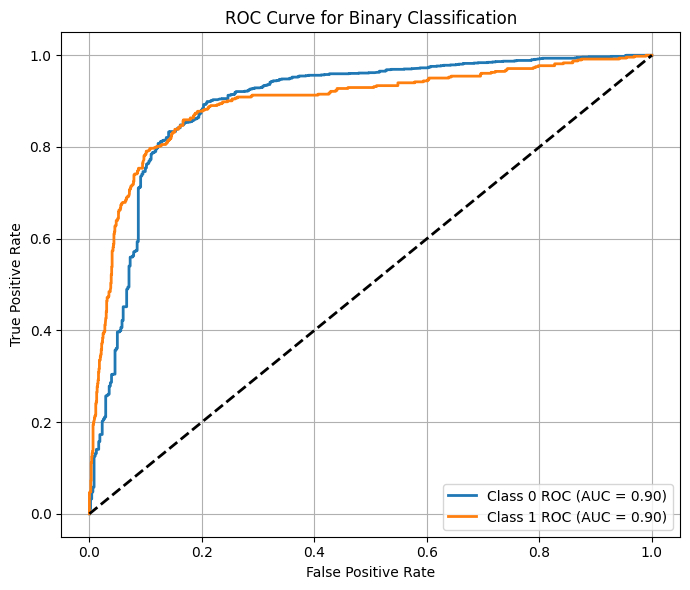

In [5]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_binary_model(model, dataloader, device):
    model.eval()
    all_true_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_input_ids, b_input_mask)
            probs = torch.softmax(outputs, dim=1)

            all_true_labels.append(b_labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # Convert to numpy
    all_true_labels = np.concatenate(all_true_labels)
    all_probs = np.concatenate(all_probs)
    all_preds = np.argmax(all_probs, axis=1)

    # ================= Metrics =================
    tn, fp, fn, tp = confusion_matrix(all_true_labels, all_preds).ravel()

    accuracy = accuracy_score(all_true_labels, all_preds)
    precision = precision_score(all_true_labels, all_preds)
    recall = recall_score(all_true_labels, all_preds)          # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(all_true_labels, all_preds)
    auc = roc_auc_score(all_true_labels, all_probs[:, 1])

    # ================= Print metrics =================
    print("===== Evaluation Metrics =====")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Sensitivity : {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1-score    : {f1:.4f}")
    print(f"AUC         : {auc:.4f}")

    # ================= Classification Report =================
    print("\n===== Classification Report =====")
    print(classification_report(all_true_labels, all_preds, digits=4))

    # ================= ROC Curve (Both Classes) =================
    fpr_0, tpr_0, _ = roc_curve(all_true_labels, all_probs[:, 0], pos_label=0)
    fpr_1, tpr_1, _ = roc_curve(all_true_labels, all_probs[:, 1], pos_label=1)

    auc_0 = roc_auc_score(1 - all_true_labels, all_probs[:, 0])
    auc_1 = roc_auc_score(all_true_labels, all_probs[:, 1])

    plt.figure(figsize=(7, 6))
    plt.plot(fpr_0, tpr_0, label=f"Class 0 ROC (AUC = {auc_0:.2f})", lw=2)
    plt.plot(fpr_1, tpr_1, label=f"Class 1 ROC (AUC = {auc_1:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Binary Classification")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, specificity, f1, auc


accuracy, precision, recall, specificity, f1, auc = evaluate_binary_model(
    model, val_dataloader, device
)

In [6]:
import re, time, random, warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW

import nltk
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


# Install if needed
# !pip install datasets nltk

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset

# ---------------------------
# Load MPQA Dataset
# ---------------------------
ds = load_dataset("jxm/mpqa")

# Convert train split to pandas (MPQA already split)
df = ds["train"].to_pandas()

print(df.head())
print(df.shape)

# MPQA typically has columns: 'text' and 'label'
# If column name is different, print df.columns to check.

# Rename for compatibility with your previous code
df = df.rename(columns={"text": "review"})

# ---------------------------
# Basic Preprocessing
# ---------------------------

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['cleaned_text'] = df['sentence'].apply(preprocess_text)

# ---------------------------
# Remove Stopwords
# ---------------------------

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    statement = statement.lower()
    statement = re.sub(r'[^\w\s]', '', statement)
    statement = re.sub(r'\d+', '', statement)
    words = statement.split()
    words = [word for word in words if word not in stop_words]
    cleaned_statement = ' '.join(words)
    return cleaned_statement

df['cleaned_text'] = df['cleaned_text'].apply(clean_statement)

print(df.head())

# ---------------------------
# Label Encoding
# ---------------------------
# MPQA labels are usually already numeric (0,1)
# But we keep this step for safety

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

print(df['label'].value_counts())

# ---------------------------
# Balance Dataset
# ---------------------------

majority_class = df['label'].value_counts().idxmax()
minority_class = df['label'].value_counts().idxmin()

df_majority = df[df['label'] == majority_class]
df_minority = df[df['label'] == minority_class]

# Downsample majority
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

# Combine
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Class Distribution:")
print(df_balanced['label'].value_counts())

df_balanced.head()
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

tokens = tokenizer(
    df_balanced["cleaned_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df_balanced["label"].values)
X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    input_ids, labels, attention_mask, test_size=0.2, random_state=42
)

train_data = TensorDataset(X_train, m_train, y_train)
val_data = TensorDataset(X_val, m_val, y_val)

train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=16)
val_loader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=16)
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def qc1(weights, x):
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([0,1])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc2(weights, x):
    qml.Hadamard(0)
    qml.RY(x[0], 0)
    qml.RX(x[1], 1)
    qml.CNOT([1,0])
    qml.RX(weights[0], 0)
    qml.RY(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc3(weights, x):
    for i in range(2):
        qml.Hadamard(i)
        qml.RX(x[i], i)
        qml.RY(weights[i], i)
        qml.RZ(weights[i], i)
    qml.CNOT([0,1])
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev, interface="torch")
def qc4(weights, x):
    qml.Hadamard(0)
    qml.CNOT([0,1])
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([1,0])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

QUANTUM_CIRCUITS = {
    "QC1": qc1,
    "QC2": qc2,
    "QC3": qc3,
    "QC4": qc4
}
class QBiLSTM(nn.Module):
    def __init__(self, quantum_circuit):
        super().__init__()
        self.qc = quantum_circuit
        self.q_weights = nn.Parameter(torch.randn(2))

        self.encoder = AutoModel.from_pretrained("microsoft/deberta-v3-base")

        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(256, 2)

    def quantum_layer(self, x):
        q_outs = []
        for v in x:
            q_outs.append(self.qc(self.q_weights, v[:2]))
        return torch.stack(q_outs)

    def forward(self, input_ids, attention_mask):
        enc = self.encoder(input_ids, attention_mask).last_hidden_state
        lstm_out, _ = self.bilstm(enc)
        h = lstm_out[:, -1, :]

        _ = self.quantum_layer(h)  # quantum interaction

        return self.fc(h)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}

for name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n====== Training {name} ======")

    model = QBiLSTM(qc).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(10):
        print(f"\n--- Epoch {epoch+1}/10 ---")
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_loader, 1):
            ids, mask, y = [b.to(device) for b in batch]

            optimizer.zero_grad()
            out = model(ids, mask)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if step % 50 == 0:  # print every 50 steps
                print(f"Step {step}: Loss = {loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} finished. Avg Loss = {avg_loss:.4f}")

    # Evaluation
    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for batch in val_loader:
            ids, mask, y = [b.to(device) for b in batch]
            logits = model(ids, mask)
            preds.extend(torch.argmax(logits, 1).cpu().numpy())
            gold.extend(y.cpu().numpy())

    acc = accuracy_score(gold, preds)
    results[name] = acc

    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(gold, preds))

print("\n===== FINAL QUANTUM CIRCUIT COMPARISON =====")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                  sentence  label
0         would not find it at all strange      0
1  that four shots would solve the problem      0
2                                  in turn      0
3                                  because      0
4                                 regained      0
(8603, 2)
                                  sentence  label  \
0         would not find it at all strange      0   
1  that four shots would solve the problem      0   
2                                  in turn      0   
3                                  because      0   
4                                 regained      0   

                     cleaned_text  
0              would find strange  
1  four shots would solve problem  
2                            turn  
3                                  
4                        regained  
label
0    6292
1    2311
Name: count, dtype: int64
Balanced Class Distribution:
label
0    2311
1    2311
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



====== Training QC1 ======

--- Epoch 1/10 ---
Step 50: Loss = 0.6693
Step 100: Loss = 0.7035
Step 150: Loss = 0.7086
Step 200: Loss = 0.7026
Epoch 1 finished. Avg Loss = 0.6988

--- Epoch 2/10 ---
Step 50: Loss = 0.6962
Step 100: Loss = 0.6931
Step 150: Loss = 0.6743
Step 200: Loss = 0.6969
Epoch 2 finished. Avg Loss = 0.6950

--- Epoch 3/10 ---
Step 50: Loss = 0.6875
Step 100: Loss = 0.7088
Step 150: Loss = 0.6886
Step 200: Loss = 0.6909
Epoch 3 finished. Avg Loss = 0.6939

--- Epoch 4/10 ---
Step 50: Loss = 0.6974
Step 100: Loss = 0.6799
Step 150: Loss = 0.6763
Step 200: Loss = 0.6966
Epoch 4 finished. Avg Loss = 0.6949

--- Epoch 5/10 ---
Step 50: Loss = 0.6957
Step 100: Loss = 0.6932
Step 150: Loss = 0.6835
Step 200: Loss = 0.6897
Epoch 5 finished. Avg Loss = 0.6938

--- Epoch 6/10 ---
Step 50: Loss = 0.6969
Step 100: Loss = 0.6847
Step 150: Loss = 0.6641
Step 200: Loss = 0.6567
Epoch 6 finished. Avg Loss = 0.6926

--- Epoch 7/10 ---
Step 50: Loss = 0.6882
Step 100: Loss = 0.6736

In [3]:
!pip install pennylane
# =========================
# 1. Imports
# =========================
import re, time, random, warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

import nltk
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# 2. Load & Clean Dataset
# =========================
ds = load_dataset("jxm/mpqa")

# Convert train split to pandas (MPQA already split)
df = ds["train"].to_pandas()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

df["cleaned_text"] = df["sentence"].astype(str).apply(clean_text)

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

# Balance classes
min_class = df["label"].value_counts().min()
df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(min_class, random_state=42))
      .sample(frac=1, random_state=42)
)

# =========================
# 3. Tokenization
# =========================
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

tokens = tokenizer(
    df["cleaned_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df["label"].values)

X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    input_ids, labels, attention_mask, test_size=0.2, random_state=42
)

train_data = TensorDataset(X_train, m_train, y_train)
val_data   = TensorDataset(X_val, m_val, y_val)

# =========================
# 4. Quantum Circuits
# =========================
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def qc1(weights, x):
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([0, 1])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc2(weights, x):
    qml.Hadamard(0)
    qml.RY(x[0], 0)
    qml.RX(x[1], 1)
    qml.CNOT([1, 0])
    qml.RX(weights[0], 0)
    qml.RY(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc3(weights, x):
    for i in range(2):
        qml.Hadamard(i)
        qml.RX(x[i], i)
        qml.RY(weights[i], i)
        qml.RZ(weights[i], i)
    qml.CNOT([0, 1])
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev, interface="torch")
def qc4(weights, x):
    qml.Hadamard(0)
    qml.CNOT([0, 1])
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([1, 0])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

QUANTUM_CIRCUITS = {
    "QC1": qc1,
    "QC2": qc2,
    "QC3": qc3,
    "QC4": qc4
}

# =========================
# 5. QBiLSTM Model
# =========================
class QBiLSTM(nn.Module):
    def __init__(self, quantum_circuit):
        super().__init__()
        self.qc = quantum_circuit
        self.q_weights = nn.Parameter(torch.randn(2))

        self.encoder = AutoModel.from_pretrained("microsoft/deberta-v3-base")

        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(257, 2)  # 256 + quantum feature

    def quantum_layer(self, x):
        q_out = [self.qc(self.q_weights, v[:2]) for v in x]
        q_out = torch.stack(q_out).unsqueeze(1)
        return q_out.float()

    def forward(self, input_ids, attention_mask):
        enc = self.encoder(input_ids, attention_mask).last_hidden_state
        lstm_out, _ = self.bilstm(enc)
        h = lstm_out[:, -1, :]

        q_feat = self.quantum_layer(h)
        h = torch.cat([h, q_feat], dim=1)

        return self.fc(h)

# =========================
# 6. Training Function
# =========================
def train_and_validate(model, params):
    train_loader = DataLoader(
        train_data, sampler=RandomSampler(train_data),
        batch_size=params["batch_size"]
    )
    val_loader = DataLoader(
        val_data, sampler=SequentialSampler(val_data),
        batch_size=params["batch_size"]
    )

    optimizer = AdamW(model.parameters(), lr=params["learning_rate"])
    loss_fn = nn.CrossEntropyLoss()

    total_steps = len(train_loader) * params["epochs"]
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 0, total_steps
    )

    for _ in range(params["epochs"]):
        model.train()
        for ids, mask, y in train_loader:
            ids, mask, y = ids.to(device), mask.to(device), y.to(device)

            optimizer.zero_grad()
            loss = loss_fn(model(ids, mask), y)
            loss.backward()
            optimizer.step()
            scheduler.step()

    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for ids, mask, y in val_loader:
            ids, mask = ids.to(device), mask.to(device)
            logits = model(ids, mask)
            preds.extend(torch.argmax(logits, 1).cpu().numpy())
            gold.extend(y.numpy())

    return accuracy_score(gold, preds)

# =========================
# 7. Hyperparameter Search
# =========================
param_grid = {
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "batch_size": [16, 32],
    "epochs": [3, 5]
}

param_list = list(ParameterSampler(param_grid, n_iter=5, random_state=42))

final_results = {}

for name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n===== {name} =====")

    best_acc = 0
    best_params = None

    for params in param_list:
        model = QBiLSTM(qc).to(device)
        acc = train_and_validate(model, params)

        print(f"{params} → Acc: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = params

    final_results[name] = (best_acc, best_params)

# =========================
# 8. Final Results
# =========================
print("\n===== FINAL COMPARISON =====")
for k, (acc, params) in final_results.items():
    print(f"{k}: Accuracy = {acc:.4f}, Params = {params}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 123.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 10.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 31.0 MB/s eta 0:00:0000:01:00:01


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]


===== QC1 =====


2026-02-14 07:47:16.046636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771055236.232994      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771055236.281383      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771055236.694404      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771055236.694442      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771055236.694445      55 computation_placer.cc:177] computation placer alr

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

{'learning_rate': 2e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.7838
{'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.6865
{'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 16} → Acc: 0.4962
{'learning_rate': 3e-05, 'epochs': 3, 'batch_size': 32} → Acc: 0.7535
{'learning_rate': 3e-05, 'epochs': 5, 'batch_size': 16} → Acc: 0.8551

===== QC2 =====
{'learning_rate': 2e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.6238
{'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.5049
{'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 16} → Acc: 0.7416
{'learning_rate': 3e-05, 'epochs': 3, 'batch_size': 32} → Acc: 0.5038
{'learning_rate': 3e-05, 'epochs': 5, 'batch_size': 16} → Acc: 0.8465

===== QC3 =====
{'learning_rate': 2e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.7557
{'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.5038
{'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 16} → Acc: 0.5622
{'learning_rate': 3e-05, 'epochs': 3, 'batch_size': 32} 

In [5]:
epochs = 5
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
optimizers = ['adamw', 'adam', 'rmsprop', 'sgd']
num_samples = 5
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def get_optimizer(optimizer_name, model_parameters, lr):
    if optimizer_name == 'adamw':
        return optim.AdamW(model_parameters, lr=lr)
    elif optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_parameters, lr=lr)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr)
final_results = {}

for qc_name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n==============================")
    print(f" Quantum Circuit: {qc_name}")
    print(f"==============================")

    best_accuracy = 0
    best_params = None

    # Random hyperparameter sampling
    random_hyperparams = [
        {
            "optimizer": random.choice(optimizers),
            "learning_rate": random.choice(learning_rates),
            "batch_size": random.choice(batch_sizes),
        }
        for _ in range(num_samples)
    ]

    for params in random_hyperparams:
        optimizer_name = params["optimizer"]
        lr = params["learning_rate"]
        batch_size = params["batch_size"]

        print(f"\n Testing {params}")

        # Fresh model for each trial (VERY IMPORTANT)
        model = QBiLSTM(qc).to(device)

        train_dataloader = DataLoader(
            train_data,
            sampler=RandomSampler(train_data),
            batch_size=batch_size
        )

        val_dataloader = DataLoader(
            val_data,
            sampler=SequentialSampler(val_data),
            batch_size=batch_size
        )

        optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
        loss_fn = nn.CrossEntropyLoss()

        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # ===== Training =====
        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            total_train_accuracy = 0

            for batch in train_dataloader:
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)

                optimizer.zero_grad()
                outputs = model(b_input_ids, b_input_mask)
                loss = loss_fn(outputs, b_labels)

                total_train_loss += loss.item()
                logits = outputs.detach().cpu().numpy()
                total_train_accuracy += flat_accuracy(logits, b_labels.cpu().numpy())

                loss.backward()
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_train_loss / len(train_dataloader)
            avg_train_accuracy = total_train_accuracy / len(train_dataloader)

            # ===== Validation =====
            model.eval()
            total_val_accuracy = 0
            total_val_loss = 0

            with torch.no_grad():
                for batch in val_dataloader:
                    b_input_ids, b_input_mask, b_labels = batch
                    b_input_ids = b_input_ids.to(device)
                    b_input_mask = b_input_mask.to(device)
                    b_labels = b_labels.to(device)

                    outputs = model(b_input_ids, b_input_mask)
                    loss = loss_fn(outputs, b_labels)

                    total_val_loss += loss.item()
                    logits = outputs.detach().cpu().numpy()
                    total_val_accuracy += flat_accuracy(logits, b_labels.cpu().numpy())

            avg_val_accuracy = total_val_accuracy / len(val_dataloader)

            print(
                f"Epoch {epoch+1} | "
                f"Train Acc: {avg_train_accuracy:.4f} | "
                f"Val Acc: {avg_val_accuracy:.4f}"
            )

        # ===== Track best =====
        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            best_params = {
                "optimizer": optimizer_name,
                "learning_rate": lr,
                "batch_size": batch_size
            }

    final_results[qc_name] = {
        "best_accuracy": best_accuracy,
        "best_params": best_params
    }

    print(f"\n BEST for {qc_name}: {best_accuracy:.4f}")
    print(f" PARAMS: {best_params}")

print("\n===== FINAL QUANTUM CIRCUIT COMPARISON =====")
for qc, res in final_results.items():
    print(
        f"{qc} | Accuracy: {res['best_accuracy']:.4f} | "
        f"Params: {res['best_params']}"
    )


 Quantum Circuit: QC1

 Testing {'optimizer': 'rmsprop', 'learning_rate': 2e-05, 'batch_size': 16}
Epoch 1 | Train Acc: 0.5005 | Val Acc: 0.5044
Epoch 2 | Train Acc: 0.5075 | Val Acc: 0.4956
Epoch 3 | Train Acc: 0.5800 | Val Acc: 0.5098
Epoch 4 | Train Acc: 0.8055 | Val Acc: 0.8586
Epoch 5 | Train Acc: 0.8866 | Val Acc: 0.8597

 Testing {'optimizer': 'adam', 'learning_rate': 2e-05, 'batch_size': 32}


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 21.12 MiB is free. Process 2818 has 15.87 GiB memory in use. Of the allocated memory 15.45 GiB is allocated by PyTorch, and 116.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

# ----- Evaluation function -----
def evaluate_model(model, dataloader, num_classes):
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)

            outputs = model(b_input_ids, b_input_mask)

            all_logits.append(outputs.cpu())
            all_labels.append(b_labels)

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()

    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    # ---- Metrics ----
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    sensitivity = recall_score(labels, preds, average="macro")  # Recall
    f1 = f1_score(labels, preds, average="macro")

    # ---- Specificity ----
    cm = confusion_matrix(labels, preds)
    specificity_per_class = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity_per_class.append(tn / (tn + fp + 1e-9))
    specificity = np.mean(specificity_per_class)

    # ---- AUC ----
    if num_classes == 2:
        auc = roc_auc_score(labels, probs[:, 1])  # binary case
    else:
        labels_bin = label_binarize(labels, classes=list(range(num_classes)))
        auc = roc_auc_score(labels_bin, probs, average="macro", multi_class="ovr")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "f1": f1,
        "auc": auc,
        "labels": labels,
        "probs": probs
    }

# ----- Number of classes -----
num_classes = len(torch.unique(train_data.tensors[2]))  # or 2 for binary

best_models_results = {}

# ----- Evaluate each best model -----
for qc_name, res in final_results.items():
    print(f"\nEvaluating BEST model for {qc_name}")

    params = res["best_params"]

    # Fresh model
    model = QBiLSTM(QUANTUM_CIRCUITS[qc_name]).to(device)

    train_loader = DataLoader(
        train_data,
        sampler=RandomSampler(train_data),
        batch_size=params["batch_size"]
    )

    val_loader = DataLoader(
        val_data,
        sampler=SequentialSampler(val_data),
        batch_size=params["batch_size"]
    )

    optimizer = get_optimizer(params["optimizer"], model.parameters(), params["learning_rate"])
    loss_fn = nn.CrossEntropyLoss()

    # ---- Retrain ----
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = loss_fn(outputs, b_labels)
            loss.backward()
            optimizer.step()

    # ---- Final Evaluation ----
    metrics = evaluate_model(model, val_loader, num_classes)
    best_models_results[qc_name] = metrics

# ----- Print Summary Table -----
print("\n===== FINAL PERFORMANCE COMPARISON =====")
print("Model | Accuracy | Precision | Sensitivity | Specificity | F1 | AUC")
print("-"*75)
for qc, m in best_models_results.items():
    print(f"{qc} | {m['accuracy']:.4f} | {m['precision']:.4f} | {m['sensitivity']:.4f} | {m['specificity']:.4f} | {m['f1']:.4f} | {m['auc']:.4f}")

# ----- Plot ROC Curves -----
for qc, m in best_models_results.items():
    labels = m["labels"]
    probs = m["probs"]

    plt.figure(figsize=(7,6))
    if num_classes == 2:
        fpr, tpr, _ = roc_curve(labels, probs[:,1])
        auc_score = roc_auc_score(labels, probs[:,1])
        plt.plot(fpr, tpr, label=f"AUC={auc_score:.3f}")
    else:
        labels_bin = label_binarize(labels, classes=list(range(num_classes)))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
            auc_i = roc_auc_score(labels_bin[:, i], probs[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc_i:.3f})")

    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {qc}")
    plt.legend()
    plt.grid(True)
    plt.show()
